# tile llc model run and distribute parcels runs

J'ai balisé avec deux étoiles (`**`) les parties qui vont sûrement nécessiter des modifs.

Le code principal est dans le [fichier suivant](https://github.com/apatlpo/mit_equinox/blob/master/mitequinox/parcels.py)

- [ ] créer le bon environnement, cf [conda.md](https://github.com/apatlpo/mit_equinox/blob/master/doc/conda.md). Ne pas oublier de mettre à jour les fichiers `jobqueue.yml et distributed.yml` dans `.dask/config/`
- [ ] parcourir ce notebook et `equinox/parcels.py` pour comprendre ce qui est fait globalement
- [ ] Finish implementing main loop around step_window (à la fin)
- [ ] verify particles transition smoothly from one grid to the next (pas du tout testé, peut-être gros morceau)
- [ ] verify what happens when a particle hit the limit of a tile: il faudrait comprendre ce que parcels fait. Je pense que les flotteurs disparaissent. Il faudrait donc trouver un moyen de les récupérer. Cela va sûrement nécessiter de relancer une (des) simulations sur la fenêtre temporelle concernée et sur le nouveau tile dans lequel le flotteur est arrivé.
- [ ] try to speed llc tiling file writing (persist dataset first). It may be faster to rewrite the full (tiled) dataset in a zarr archive.
- [ ] adjust tile size and overlap if necessary (may have to wait full dataset runs)
- [ ] run particle simulation on full dataset (pas du tout testé, peut-être gros morceau)
- [ ] try to change time stepping scheme: RK4
- [ ] write a function to load dataset into xarray or dask.dataframe


In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed

%matplotlib inline
from matplotlib import pyplot as plt

import xgcm

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
# ** processes and cores may be adjusted in order to have more memory or inversely more computational ressource
#cluster = PBSCluster(processes=4, cores=4, walltime='04:00:00')
#cluster = PBSCluster(walltime='04:00:00')
#cluster = PBSCluster()
#w = cluster.scale(jobs=5)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39703 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 67.17 GB


---
## setup directories and run parameters

In [3]:
#root_dir = ut.root_data_dir+'parcels/'
#root_dir = '/home1/scratch/aponte/parcels/'
root_dir = '/home1/dunree/slgentil/tmp/parcels/'

run_name = 'test'
overwrite = False

# create or overwrite run_dir
run_dir = root_dir+run_name
if os.path.isdir(run_dir):
    if overwrite:
        shutil.rmtree(run_dir)
        os.mkdir(run_dir)
    else:
        #assert False, 'You need to archive the following directory:\n'+run_dir
        pass
else:
    os.mkdir(run_dir)

In [4]:
# simulation parameters

#T = 360? # length of the total run [days]
T = 20 # ** debug
#dt_windows = 5 # time window
dt_windows = 2 # ** debug, 5j devrait être plus approprié je pense
dt_stepping = 1 # hours
dt_outputs = 1 # hours

dij_init = 10 # initial position subsampling compared to llc grid

---

## load llc data

In [5]:
# load llc data
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

---

## create tiles

This could be done somewhere else, in another notebook

See `rearrange.ipynb` and `tile.ipynb` for more details

** Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant

In [6]:
%%time
create_tiles = False
tile_dir = os.path.join(run_dir,'tiling/')

if create_tiles:
    
    # ** could filter out tiles that are empty, criterium on Depth or SST should be sufficient

    # create tiler
    tl = pa.tiler(ds=grd.reset_coords(), factor=(10, 10), overlap=(100, 100))
    # store tiler
    tl.store(tile_dir)
    
else:
    
    #tile_dir = ut.root_data_dir+'parcels/tiling/'
    #tile_dir = os.path.join(run_dir,'tiling/')
    tl = pa.tiler(tile_dir=tile_dir)
    
tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
                  for t in range(tl.N_tiles)
                 ]

CPU times: user 453 ms, sys: 65.9 ms, total: 519 ms
Wall time: 569 ms


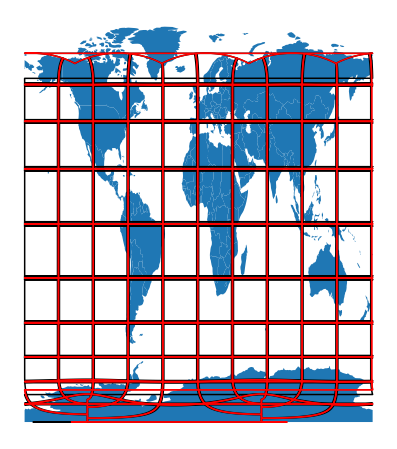

CPU times: user 40.7 s, sys: 24.1 s, total: 1min 4s
Wall time: 23.2 s


In [7]:
%%time
crs = tl.crs_wgs84

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in tl.G['boundaries']:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
ax.set_axis_off()
plt.show()

In [9]:
%%time
# create a tree of directories to store data
for t in tile_data_dirs:
    os.mkdir(t)

CPU times: user 4.12 ms, sys: 1.81 ms, total: 5.93 ms
Wall time: 4.7 ms


---

## !!Not used for now!! 

initial distribution of floats is performed within `step_window` now.

We start from llc grid

In [ ]:
dij = 100 # 1 float every 10 grid points
x = (grd[['XC','YC']]
          .isel(i=slice(0,None,dij), j=slice(0,None,dij))
          .stack(drifter=('i','j','face'))
          .reset_coords()
         )
x = x.where(x.Depth>0, drop=True).persist()

x.plot.scatter(x='XC', y='YC', hue='Depth', s=2, size=10)

In [ ]:
# assign to tiles
#df_tiles = tl.assign(lon=x_init.XC, lat=x_init.YC)

# distributed version
def assign(lon, lat):
    #import mitequinox.parcels as pa
    #tile_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/tiling/'
    tl = pa.tiler(tile_dir=tile_dir)
    df = tl.assign(lon=lon.squeeze(), lat=lat.squeeze())
    return df.values

x['tiles'] = xr.apply_ufunc(assign, 
                            x.XC, x.YC, 
                            dask='parallelized', 
                            output_dtypes=[int]
                           ).persist()

In [ ]:
%time x.plot.scatter(x='XC', y='YC', hue='tiles', s=3, size=10, vmin=0, vmax=tl.N_tiles)
# dij=100, single node: 1 min35s
# dij=100, 5x(4,4) cluster: 2 min 5s

In [ ]:
# drop -1 (drifter without box)
x = x.where(x.tiles>-1, drop=True)

In [ ]:
x = (x
     .rename({'XC': 'lon', 'YC': 'lat'})
     .drop_vars(['CS','SN','rA'])
    )

In [ ]:
# store in file to be processed
def store_floats_init(x):
    ''' store initial float positions
    '''
    tile = int(x.tiles.values[0])
    x = x.chunk({'drifter': -1}).reset_index('drifter')
    x.to_netcdf(os.path.join(tile_data_dirs[tile], 'x_init.nc'), mode='w')
    return x.mean(dim='drifter')

x_mean = x.groupby('tiles').apply(store_floats_init)
x_mean.lon.plot()

--- 

## tests on one window


### rewrite llc data into tiles

** Bottle neck to the whole computation: 

1. it may be more efficient to rewrite the full dataset once with a large dask cluster
2. use zarr files

In [8]:
%%time
# store data, may not be necessary eventually

# Note:inspection of dash board confirms data for each tile is spread all over workers
# we may be able to do better by assigning each tile objects to a worker
#    see https://distributed.dask.org/en/latest/locality.html#user-control

t=0
ds_tiles = pa.tile_store_llc(ds,
                  slice(t, t+dt_windows*24, None),
                  tl,
                  tile_data_dirs,
                 )
print(ds_tiles[5])

# does not go through if data has been persisted before hand !? bizar
# we are probably creating more data reads than necessary with the present solution

# dt_windows = 2d, 10x10 tiles, 35 workers on 5 nodes: 15min
# increasing number of workers does not seem to help: disk access is probably the limiting factor

100%|██████████| 100/100 [00:05<00:00, 17.70it/s]

<xarray.Dataset>
Dimensions:  (i: 1828, j: 1386, time: 48)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 1821 1822 1823 1824 1825 1826 1827
  * time     (time) datetime64[ns] 2011-11-15 ... 2011-11-16T23:00:00
  * j        (j) int64 6430 6431 6432 6433 6434 ... 7811 7812 7813 7814 7815
    niter    (time) int64 dask.array<chunksize=(48,), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    XG       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    YG       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    rAz      (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.n

In [9]:
# same but not working, reasons unclear, we may be asking too much to the scheduler 
# as data is spread over all workers
if False:
    # with D items (tiles) persisted
    delayed_results = []
    for tile, ds_tile in enumerate(D):
        nc_file = os.path.join(tile_data_dirs[tile], 'llc.nc')
        delayed = ds_tile.to_netcdf(nc_file, compute=False)
        delayed_results.append(delayed)
        
    results = dask.compute(*delayed_results)

### test on one tile, one window

In [9]:
%%time
# test on one tile
step = 0
tile = 5
dij = 100
#psize = pa.step_window(tile, step, dt_windows, tl, run_dir, init_dij=dij, 
#                                  parcels_remove_on_land=True)

psize = pa.step_window(tile, step, dt_windows, tl, run_dir, ds_tiles=ds_tiles, init_dij=dij, 
                                  parcels_remove_on_land=True)

<xarray.Dataset>
Dimensions:  (i: 1828, j: 1386, time: 48)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 1821 1822 1823 1824 1825 1826 1827
  * time     (time) datetime64[ns] 2011-11-15 ... 2011-11-16T23:00:00
  * j        (j) int64 6430 6431 6432 6433 6434 ... 7811 7812 7813 7814 7815
    niter    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    XG       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    YG       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    rAz      (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(1386, 1828), meta=np.nd

INFO: Compiled JITParticleRemoveOnLand ==> /tmp/parcels-16088/76b9ea09a402702db2f56421c563ee56_0.so
INFO: Compiled JITParticleAdvectionEE ==> /tmp/parcels-16088/43c34966cdf89818cd2d0c9a15097e0e_0.so
INFO: Temporary output files are stored in /home1/dunree/slgentil/tmp/parcels/test/data_005/out-VTJXBLDK.
INFO: You can use "parcels_convert_npydir_to_netcdf /home1/dunree/slgentil/tmp/parcels/test/data_005/out-VTJXBLDK" to convert these to a NetCDF file during the run.
100% (172800.0 of 172800.0) |############| Elapsed Time: 0:00:07 Time:  0:00:07


CPU times: user 27.6 s, sys: 23.1 s, total: 50.7 s
Wall time: 1min 5s


<xarray.Dataset>
Dimensions:     (obs: 49, traj: 218)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 dask.array<chunksize=(218, 49), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(218, 49), meta=np.ndarray>
    lat         (traj, obs) float64 dask.array<chunksize=(218, 49), meta=np.ndarray>
    lon         (traj, obs) float64 dask.array<chunksize=(218, 49), meta=np.ndarray>
    z           (traj, obs) float64 dask.array<chunksize=(218, 49), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical
CPU times: user 61 ms, sys: 0 ns, total: 61 ms
Wall time: 55.2 ms


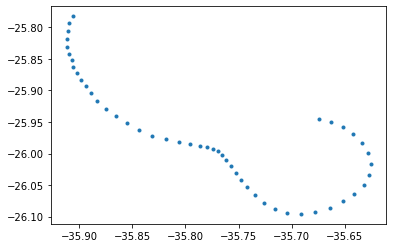

In [10]:
%%time
flt = 0
tile_dir = tile_data_dirs[tile]
file = 'floats_{:03d}_{:03d}.nc'.format(step, tile)
tds = xr.open_mfdataset(os.path.join(tile_dir, file))
print(tds)
plt.plot(tds.lon.isel(traj=flt),tds.lat.isel(traj=flt),'.')

### distribute parcels computations over tiles

In [8]:
step = 0
dij = 10
dsteps = [delayed(pa.step_window)(tile, step, dt_windows, tl, run_dir,
                                  init_dij=dij, 
                                  parcels_remove_on_land=True,
                                 ) 
          for tile in range(tl.N_tiles)
         ]
dsteps_out = dask.compute(*dsteps)

--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted within tile_store_llc)


In [ ]:
dij = 10

for step, t in enumerate(np.arange(0,T, dt_windows)):
    
    # load, tile and store llc data
    tile_store_llc(t)
    
    # distribute parcels computations
    dsteps = [delayed(pa.step_window)(tile, step, dt_windows, tl, run_dir,
                                  init_dij=dij, 
                                  parcels_remove_on_land=True,
                                 ) 
              for tile in range(tl.N_tiles)
             ]
    dsteps_out = dask.compute(*dsteps)    
    
    # ** remove data from memory manually

---
## load dataset and plot a subset of trajectories

In [ ]:
# ds = xr.open_mfdataset(...)

---

In [ ]:
cluster.close()